# Forest Fires in Northeast Portugal

![fire](https://images.unsplash.com/photo-1600181958051-bd8544360312?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&w=1469&q=80)

### Table of Contents

* [Introduction](#Introduction)
* [Import Libraries](#Lib)
* [Data Overview](#Data)
* [Graphical Plots](#Graph)
* [Filling Missing Data](#Miss)
* [Splitting the Data](#Split)
* [Scaling the Data and Initial Model](#Scale)
* [Alternative Linear Model](#Alt)
* [Removal of Outliers](#Out)
* [Model Optimization](#Model)
* [Training and Test Size Determination](#Train)
* [Alpha Optimization and PCA Implementation](#PCA)
* [Polynomial and Spline Transformation](#Poly)
* [Conclusion](#Conclusion)



<a id='Introduction'></a>
## Introduction

The aim is to predict burn area of forest fires from [dataset](https://archive.ics.uci.edu/ml/datasets/Forest+Fires) collected from northeast region of Portugal.  To do this a linear regression model will be used.  

The dataset uses the [Fire Weather Index (FWI) System](https://www.nwcg.gov/publications/pms437/cffdrs/fire-weather-index-system) for quantifying fire hazard related data.  





### Features

* X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
* Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
* month - month of the year: 'jan' to 'dec'
* day - day of the week: 'mon' to 'sun'
* FFMC - FFMC index from the FWI system (fuel moisture of forest litter): 18.7 to 96.20
* DMC - DMC index from the FWI system (fuel moisture of decomposed organic material underneath the litter): 1.1 to 291.3
* DC - DC index from the FWI system (drying deep into the soil): 7.9 to 860.6
* ISI - ISI index from the FWI system (initial spread index): 0.0 to 56.10
* temp - temperature in Celsius degrees: 2.2 to 33.30
* RH - relative humidity in %: 15.0 to 100
* wind - wind speed in km/h: 0.40 to 9.40
* rain - outside rain in mm/m2 : 0.0 to 6.4
* area - the burned area of the forest (in ha): 0.00 to 1090.84




<a id='Lib'></a>
## Import Libraries

In [73]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, SplineTransformer, PolynomialFeatures
from sklearn.pipeline import make_pipeline


# set seaborn style for plots
sns.set_style(style="darkgrid")

In [74]:
# read dataset csv file into pandas dataframe
fire=pd.read_csv('/content/drive/MyDrive/fires.csv')


<a id='Data'></a>
## Data Overview

In [75]:
# information on inital dataset
fire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  517 non-null    int64  
 1   X           517 non-null    int64  
 2   Y           517 non-null    int64  
 3   month       517 non-null    object 
 4   day         517 non-null    object 
 5   FFMC        469 non-null    float64
 6   DMC         496 non-null    float64
 7   DC          474 non-null    float64
 8   ISI         515 non-null    float64
 9   temp        496 non-null    float64
 10  RH          487 non-null    float64
 11  wind        482 non-null    float64
 12  rain        485 non-null    float64
 13  area        517 non-null    float64
dtypes: float64(9), int64(3), object(2)
memory usage: 56.7+ KB


In [76]:
# first five rows of dataset
fire.head()

,Unnamed: 0,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,1,7,5,mar,fri,86.2,26.2,94.3,5.1,NaN,51.0,6.7,0.0,0.0
1,2,7,4,oct,tue,90.6,NaN,669.1,6.7,18.0,33.0,0.9,0.0,0.0
2,3,7,4,oct,sat,90.6,43.7,NaN,6.7,14.6,33.0,1.3,0.0,0.0
3,4,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97.0,4.0,0.2,0.0
4,5,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99.0,NaN,0.0,0.0


There are a few null values that need to be dealt with later on.  *Unnamed:0* column is the same as the index and needs to be dropped.  *Month* and *day* columns are both *string* type and need to be changed to numerical values or removed.  Specific day of the week is unlikely to be of much factor in forest fires and can be eliminated.  Time of the year delineated by month may have an effect amount of forest fire due to affect of seasons on the weather.  *Month* column will be transformed into numerical values (1=January, 2=February .... etc). 

*X* and *Y* columns have to do with various locations in the forest.  These values are relatively catagorical and not ordinal.  While it is possible to transform these columns into various dummy variables.  This approach might make the dataset more unweildy with too many features.  It is preferable to remove these columns for simplicities sake.

In [77]:
# drop unneeded columns
fire=fire.drop(columns=['Unnamed: 0', 'day', 'X', 'Y'])

# create dictionary for numerical values correlating to month names in month column
month_dic={'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}

# map dictionary to month column values
fire['month']=fire['month'].map(month_dic)

# info of dataset
fire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   month   517 non-null    int64  
 1   FFMC    469 non-null    float64
 2   DMC     496 non-null    float64
 3   DC      474 non-null    float64
 4   ISI     515 non-null    float64
 5   temp    496 non-null    float64
 6   RH      487 non-null    float64
 7   wind    482 non-null    float64
 8   rain    485 non-null    float64
 9   area    517 non-null    float64
dtypes: float64(9), int64(1)
memory usage: 40.5 KB


<a id='Graph'></a>
## Graphical Plots

Inital plots of data in dataset.

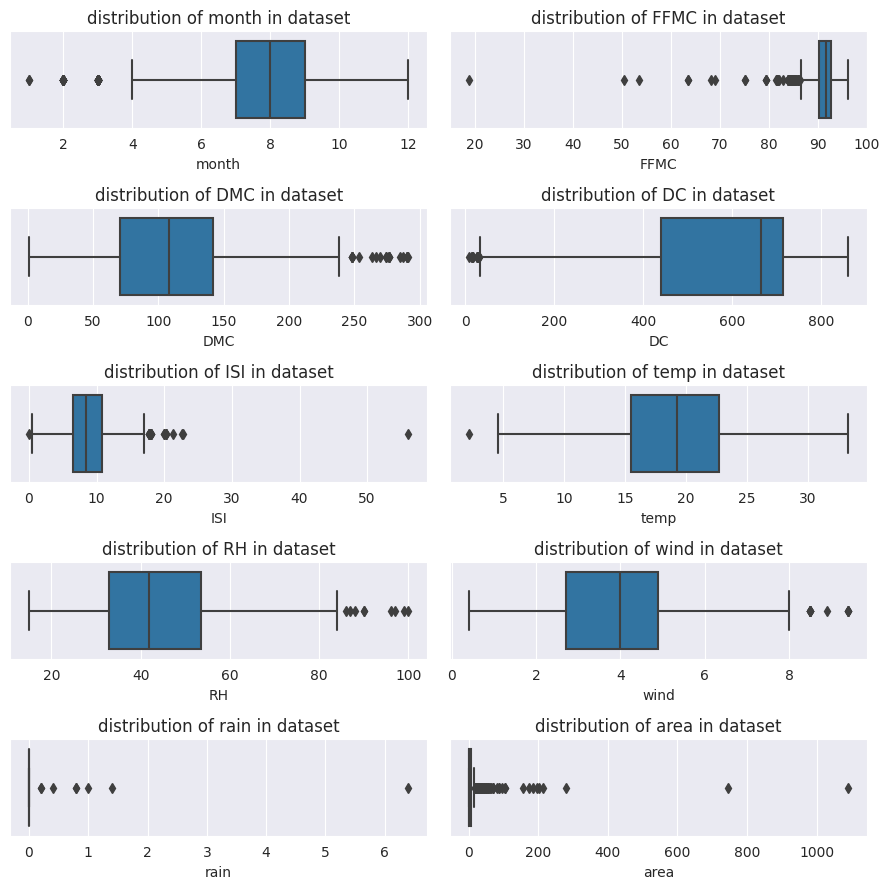

In [78]:
# set figsize
plt.figure(figsize=(9,9))

# loop through column names and plot distributions
for i, col in enumerate(fire.columns):

  # set subplot
  plt.subplot(5,2,i+1)

  # seaborn boxplot
  sns.boxplot(data=fire, x=col)
  plt.title(f'distribution of {col} in dataset')

# minimize risk of subplots overlapping
plt.tight_layout()

# show final plot after subplots finished generating
plt.show()  

Features with extreme outliers:

* FFMC
* DMC
* DC
* ISI
* RH
* Rain
* area

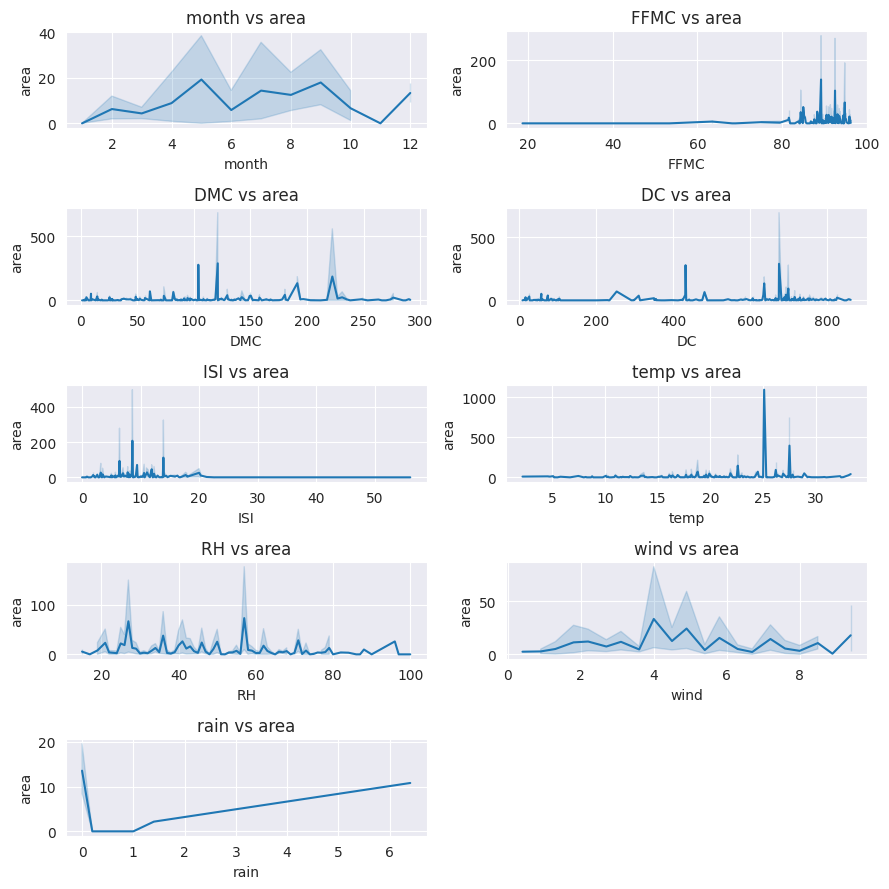

In [79]:
# generate list of predictive column 
column_names=fire.drop(columns=['area'])
column_names=column_names.columns

# set figsize
plt.figure(figsize=(9,9))

# loop through predictive column names and create lineplots with x=column name and y=outcome variable (area)
for i, col in enumerate(column_names):
  plt.subplot(5,2,i+1)
  sns.lineplot(data=fire, y='area', x=col) # seaborn lineplot
  plt.title(f'{col} vs area')

# show figure
plt.tight_layout()
plt.show()  

Above are plots of various predictor variables vs outcome variable *area*:

* Fires are typically between April and October
* Fires corrospond to higher values of FFMC (fuel moisture of forest litter)
* Fires corrospond to about 100 DMC or greater (fuel moisture of decomposed organic material underneath the litter)
* Fires typically more severe with a DC (drying deep into the soil) of 400 or greater
* When ISI (initial spread index) is below 20 fires are more severe
* Higher temps correlate strongly with fire severity and size 
* RH (relative humidity) has weak corrolation with fire severity
* Wind of 4 km/hour or greater typically increase fire area
* Times of little to no rain corrospond to larger fires, however increasing rains can also indicate increased risk of forest fire.  This is likely due to lightning strikes. 


Text(0.5, 1.0, "Pearson's Correlation heatmap")

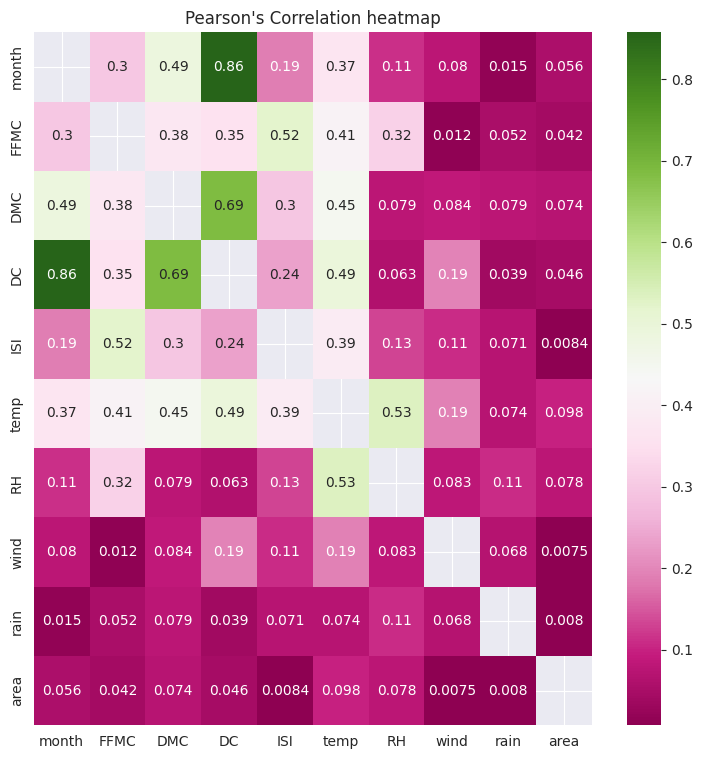

In [80]:
# calculate correlations in dataset
corr=abs(fire.corr())

# plot correlations using heatmap
plt.figure(figsize=(9,9))
sns.heatmap(corr[corr<1], cmap='PiYG', annot=True)
plt.title("Pearson's Correlation heatmap")

Correlations of the predictor variables are all very weak with outcome varaible *area*.  Because of this there are few clear choses of features to use for optimum performance.  All features will be used as the amount of variables in datset are relativly low and size of datset is fairly small.

<a id='Miss'></a>
## Filling Missing Data

Next will need to fill missing data as the models will not fuction with missing data.  Will use method that fills missing data with a k-nearest neighbors [algorithm.](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html)  

In [81]:
# initialize KNNImputer object
imp=KNNImputer(missing_values=np.nan, n_neighbors=3)

# create new DataFrame with NaN data filled in by KNNINputer
fire_imp=pd.DataFrame(imp.fit_transform(fire), columns=fire.columns)
fire_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   month   517 non-null    float64
 1   FFMC    517 non-null    float64
 2   DMC     517 non-null    float64
 3   DC      517 non-null    float64
 4   ISI     517 non-null    float64
 5   temp    517 non-null    float64
 6   RH      517 non-null    float64
 7   wind    517 non-null    float64
 8   rain    517 non-null    float64
 9   area    517 non-null    float64
dtypes: float64(10)
memory usage: 40.5 KB


<a id='Split'></a>
## Splitting Data and Inital Model

Split data into predictor and outcome variables and then split those datasets into further training and testing datsets.  Next will build initial linear regression model with default parameters.  

[Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error) will be used to determine accuracy of the models.  If the model was 100% accurage, the MSE would be zero.  As variance between predicted values vs actual values increase so will the resulting MSE.  The best model will be determined by the lowest MSE.
$$
MSE = \frac{1}{n} \sum_{i=1}^{n}(y_i-\hat{y_i})^2
$$

In [82]:
# split data into predictor and outcome datasets
X=fire_imp.drop(columns='area')
y=fire_imp['area']

# split data into training and test sets
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=36)

# initaliaze Linear Regression object with default parameters
model=LinearRegression()

# fit model with training data
model.fit(X_train,y_train)

# generate predictions based off of model
prediction=model.predict(X_test)

# calculate mean squared error and print results
mse=mean_squared_error(y_test, prediction)
print(f'Initial mean squared error of the model is {mse:.2f}')

Initial mean squared error of the model is 11979.15


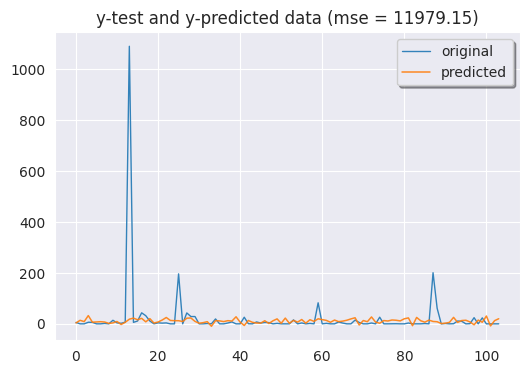

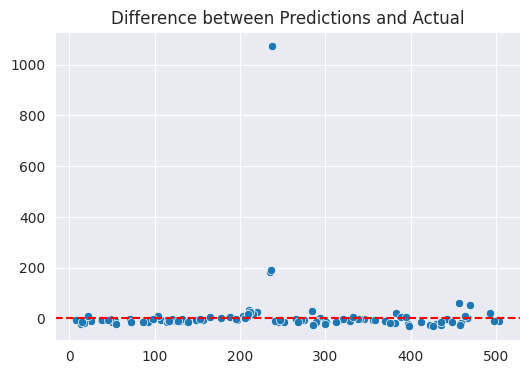

In [83]:
# Create function to create line plot of predicted values vs actual values
def graph_test_accuracy(y_test, y_pred, mse):
    plt.figure(figsize=(6,4))
    x_ax = range(len(y_test)) # determine range of x-axis based of len of y_test
    plt.plot(x_ax, y_test, linewidth=1, label="original", alpha=0.9)
    plt.plot(x_ax, y_pred, linewidth=1.1, label="predicted", alpha=0.9)
    plt.title(f"y-test and y-predicted data (mse = {mse:.2f})")
    plt.xlabel('')
    plt.ylabel('')
    plt.legend(fancybox=True, shadow=True, loc='best')
    plt.grid(True)
    plt.show()

 # add scatterplot that plots variance between predicted and actual values   
    plt.figure(figsize=(6,4))   
    variance=y_test-prediction # create dataframe of the difference between actual values and prediction
    sns.scatterplot(variance)
    plt.axhline(y = 0, color = 'r', linestyle = '--') # horizantal line that indicates where there is 0 variance
    plt.title('Difference between Predictions and Actual')
    plt.ylabel('')
    plt.xlabel('') 
    plt.show()

# graph results    
graph_test_accuracy(y_test, prediction, mse) 

MSE starts off at almost 12,000 from the initial model.  The variance between predicted and actual values are mostly relatively close to 0 with a few outliers.

Will first attempt to improve accuracy by scaling the predictor variables to a standard scale using [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).


<a id='Scale'></a>
## Scaling the Data

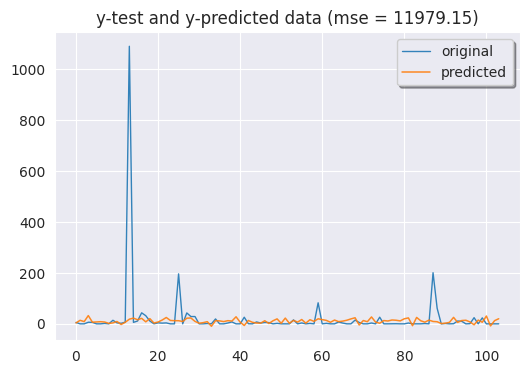

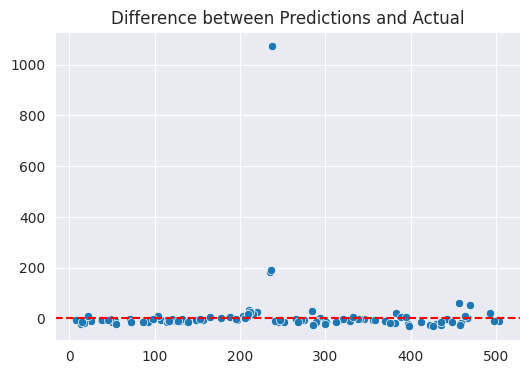

In [84]:
# scaled predictor dataset to standard scale
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)

# split scaled data to train and test datasets
X_train, X_test, y_train, y_test=train_test_split(X_scaled, y, test_size=0.2, random_state=36)

# initialize
model=LinearRegression()
model.fit(X_train, y_train)
prediction=model.predict(X_test)
mse=mean_squared_error(y_test, prediction)

# graph results
graph_test_accuracy(y_test, prediction, mse) 

There was no improvement in the results after scaling the data.  Next will try out different linear models.

<a id='Alt'></a>
## Alternative Linear Model

First will try [RidgeCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html) linear regression model with default parameters.  

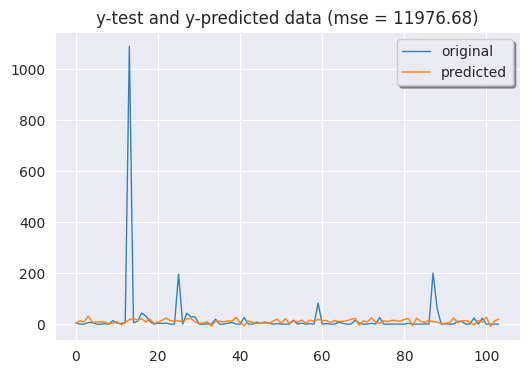

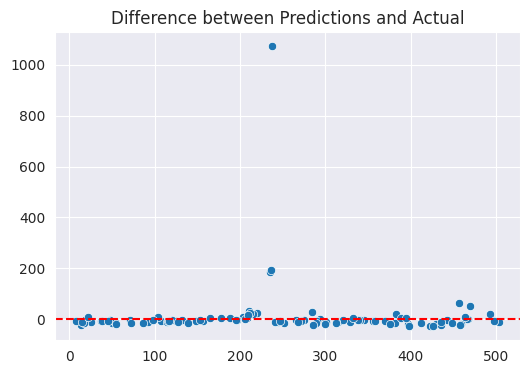

In [85]:
# initialize RidgeCV object with default parameters
model=RidgeCV()

# fit model with training data
model.fit(X_train , y_train)

# make predictions and calculate mse
prediction=model.predict(X_test)
mse=mean_squared_error(y_test, prediction)

# plot results
graph_test_accuracy(y_test, prediction, mse) 

Minuscule decrease in MSE using RidgeCV versus simple Linear Regression.  Will next use [LassoCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html) linear regression model with default parameters.

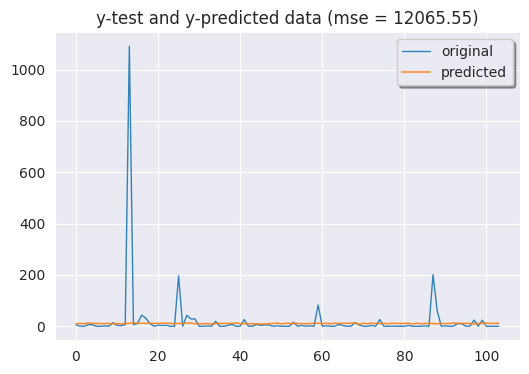

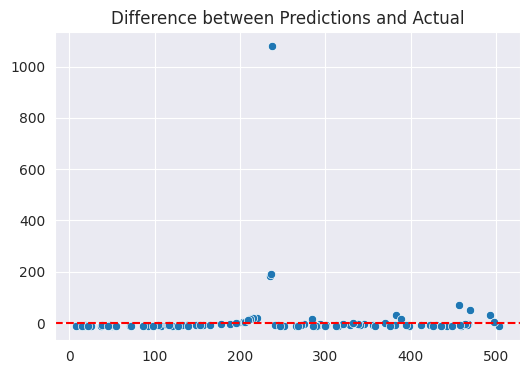

In [86]:
# initialize LassoCV object with default parameters
model=LassoCV()

# fit training data to model
model.fit(X_train , y_train)

# make predictions, calculate mse and plot results
prediction=model.predict(X_test)
mse=mean_squared_error(y_test, prediction)
graph_test_accuracy(y_test, prediction, mse) 

LassoCV model performed worse than both RidgeCV and simple Linear Regression.  Will use RidgeCV model for the rest of the project.

<a id='Out'></a>
## Removal of Outliers

Next will try to improve performance in the linear regression models by removing outliers.  Will determine what outliers to remove with stadard deviation.  Only want to remove the most extreme outliers so will use a broad range of +/- 4 standard deviations on what data to keep.  

In [87]:
# sort values in fire_imp dataset by area.
fire_imp.sort_values('area', ascending=False).head(10)

,month,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
238,9.0,92.5,121.1,674.400000,8.6,25.1,27.0,4.0,0.0,1090.84
415,8.0,94.8,222.4,698.600000,13.9,27.5,27.0,4.9,0.0,746.28
479,7.0,89.2,103.9,431.600000,6.4,22.6,57.0,4.0,0.0,278.53
237,9.0,91.0,129.5,692.600000,7.0,18.8,40.0,2.2,0.0,212.88
236,9.0,92.5,121.1,674.400000,8.6,18.2,46.0,1.8,0.0,200.94
235,8.0,91.4,142.4,680.466667,10.6,19.6,41.0,5.8,0.0,196.48
420,8.0,91.7,191.4,635.900000,7.8,26.2,36.0,4.5,0.0,185.76
377,8.0,93.7,231.1,715.100000,8.4,21.9,42.0,2.2,0.0,174.63
234,9.0,92.5,121.1,674.400000,8.6,17.7,25.0,3.1,0.0,154.88
233,9.0,84.4,73.4,477.666667,3.2,24.3,36.0,3.1,0.0,105.66


In [88]:
fire_imp.describe()

,month,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,7.475822,90.663765,110.919084,547.759897,9.016054,18.904771,44.360413,4.016699,0.021663,12.847292
std,2.275990,5.489523,63.436583,244.886096,4.556973,5.716612,15.884818,1.769632,0.295959,63.655818
min,1.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,7.000000,90.300000,70.800000,440.900000,6.500000,15.600000,33.000000,2.700000,0.000000,0.000000
50%,8.000000,91.600000,108.300000,661.300000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,9.000000,92.800000,141.300000,706.700000,10.700000,22.800000,53.000000,4.900000,0.000000,6.570000
max,12.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


In [89]:
# set standard_deviation range to keep to 4.  Only eliminate extreme outliers.
standard_deviations=4

# lamda function that removes any row with values outside of 4 deviations from the mean
clean_fire=fire_imp[fire_imp.apply(lambda x: np.abs(x - x.mean()) / x.std() < standard_deviations)
   .all(axis=1)]

# drop any rows with null values
clean_fire=clean_fire.dropna()

# calculate percentage of dataset left after removal of outliers
percent_kept=clean_fire.shape[0]/fire.shape[0]*100
print(f'Percent of dataset left {percent_kept:.2f}%')

Percent of dataset left 97.68%


In [90]:
# sort values in cle_imp dataset by area.
clean_fire.sort_values('area', ascending=False).head(10)

,month,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
237,9.0,91.0,129.5,692.600000,7.0,18.8,40.0,2.2,0.0,212.88
236,9.0,92.5,121.1,674.400000,8.6,18.2,46.0,1.8,0.0,200.94
235,8.0,91.4,142.4,680.466667,10.6,19.6,41.0,5.8,0.0,196.48
420,8.0,91.7,191.4,635.900000,7.8,26.2,36.0,4.5,0.0,185.76
377,8.0,93.7,231.1,715.100000,8.4,21.9,42.0,2.2,0.0,174.63
234,9.0,92.5,121.1,674.400000,8.6,17.7,25.0,3.1,0.0,154.88
233,9.0,84.4,73.4,477.666667,3.2,24.3,36.0,3.1,0.0,105.66
232,9.0,91.0,129.5,692.600000,7.0,18.7,43.0,2.7,0.0,103.39
231,9.0,93.5,149.3,607.666667,8.1,27.8,27.0,3.1,0.0,95.18
230,9.0,92.9,117.4,699.600000,9.2,26.4,21.0,4.5,0.0,88.49


In [91]:
clean_fire.describe()

,month,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000
mean,7.493069,91.084290,111.231815,549.406733,9.013267,18.903300,44.014521,4.007591,0.006733,8.915030
std,2.266135,3.220060,63.410461,244.904530,3.984997,5.691435,15.506463,1.768024,0.070389,24.855379
min,1.000000,69.000000,2.400000,7.900000,0.700000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,7.000000,90.333333,73.400000,442.900000,6.600000,15.700000,33.000000,2.700000,0.000000,0.000000
50%,8.000000,91.666667,108.400000,661.300000,8.400000,19.200000,42.000000,4.000000,0.000000,0.520000
75%,9.000000,92.800000,141.300000,707.266667,10.700000,22.800000,53.000000,4.900000,0.000000,6.440000
max,12.000000,96.200000,291.300000,860.600000,22.700000,33.300000,99.000000,9.400000,1.000000,212.880000


Kept 97.68% of original dataset and lost only 12 rows after removing outliers.

<a id='Model'></a>
## Model Optimization

Will run model with new cleaned dataset and then start to optimize the RidgeCV parameters.

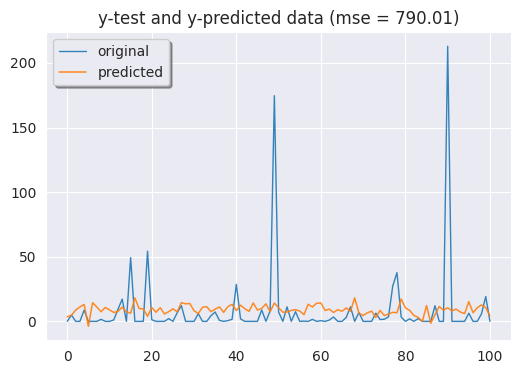

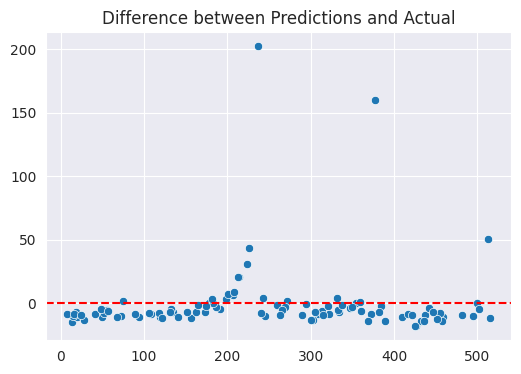

In [92]:
# split data into predictor and outcome variables from dataset with removed outliers
X_clean=clean_fire.drop(columns='area')
y_clean=clean_fire['area']

# split data into training and test datasets
X_train, X_test, y_train, y_test=train_test_split(X_clean, y_clean, test_size=0.2, random_state=36)

# initialize RidgeCV object with default parameters
model=RidgeCV()

# fit training data to model
model.fit(X_train, y_train)

# make predictions, calculate mse and graph results
prediction=model.predict(X_test)
mse=mean_squared_error(y_test, prediction)
graph_test_accuracy(y_test, prediction, mse) 

Improvement in MSE of 11,977 to 790 after running RidgeCV linear regression with data without outliers.


<a id='Train'></a>
## Training and Test Size Determination

Next we will explore if we can improve accuracy of the model by changing the size of the training and corrosponding test datasets.  To do this we will use cross validation. Incresing K-folds tend to improve accuracy at the cost of precision and increasing computing resources.

[A higher k (number of folds) means that each model is trained on a larger training set and tested on a smaller test fold. In theory, this should lead to a lower prediction error as the models see more of the available data.
A lower k means that the model is trained on a smaller training set and tested on a larger test fold. Here, the potential for the data distribution in the test fold to differ from the training set is bigger, and we should thus expect a higher prediction error on average.](https://cran.r-project.org/web/packages/cvms/vignettes/picking_the_number_of_folds_for_cross-validation.html)


Next will look use the sklearn [cross val score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) method with various cv values with scoring by 'neg_mean_squared_error.

In [93]:
# generate default RidgeCV object
model = RidgeCV()

# return cross val scores with different numbers of folds
k2=cross_val_score(model, X_clean, y_clean, cv=2, scoring = 'neg_mean_squared_error')
k5=cross_val_score(model, X_clean, y_clean, cv=5, scoring = 'neg_mean_squared_error')
k10=cross_val_score(model, X_clean, y_clean, cv=10, scoring = 'neg_mean_squared_error')
k20=cross_val_score(model, X_clean, y_clean, cv=20, scoring = 'neg_mean_squared_error')

# create lists of k-fold means and standard deviations
avgs=[k2.mean(), k5.mean(), k10.mean(), k20.mean()]
stds=[k2.std(), k5.std(), k10.std(), k20.std()]

# create dataframe from above lists.
cross_validation=pd.DataFrame([avgs, stds]).transpose()
cross_validation=cross_validation.rename(columns={0:'mean', 1: 'std'}, index={0:'k2', 1:'k5', 2:'k10', 3:'k20'})
cross_validation

,mean,std
k2,-692.666289,115.507271
k5,-683.567592,757.112036
k10,-660.593523,1129.167627
k20,-642.762970,1246.444133


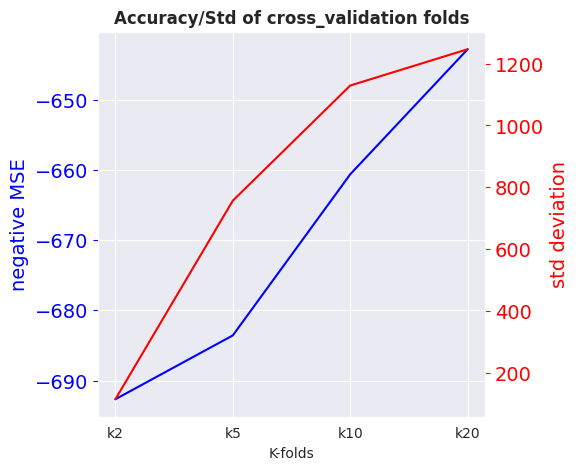

In [94]:
# plot cross_validation dataframe

# set figsize
plt.figure(figsize=(5,5))

# set up ax1 
ax1=sns.lineplot(
    x=cross_validation.index, 
    y='mean', 
    data=cross_validation,
    color='blue'
)
ax1.set_title('Accuracy/Std of cross_validation folds', weight='bold')
ax1.set_ylabel('negative MSE')
# ax1.set_ylim(0, .9)
# ax1.legend(['(split) accuracy'], loc="upper left") #legend title/location
ax1.yaxis.label.set_color('blue')
ax1.yaxis.label.set_fontsize(14)
ax1.tick_params(axis='y', labelsize=14, colors='blue')
ax1.set_xlabel('K-folds')

# set up ax2 (n_iter plot for split-apply-combine feature order)
ax2 = ax1.twinx()
sns.lineplot(
    data=cross_validation,
    x=cross_validation.index,
    y='std',
    color='red', 
    ax = ax2       # Pre-existing axes for the plot
)

ax2.grid(False) # turn off grid #2
ax2.set_ylabel('std deviation')
# ax2.set_ylim(0, 1300)
# ax2.legend(['(split) n_iter'], loc="center") #legend title/location
ax2.yaxis.label.set_color('red')
ax2.yaxis.label.set_fontsize(14)
ax2.tick_params(axis='y', colors='red', labelsize=14)

Increasing K-folds from k2 to k20 improves negative MSE score, however leads to great increase in standard deviation.  2 or 5 folds are the ideal balance between MSE score and standard deviation.  5 folds roughly corrosponds to 80/20 training/test devision that has already been used in the current models.  No change will be made in training and test split.


<a id='PCA'></a>
## Alpha Optimization and PCA Implementation

Next will try to improve the model by optimizing the alpha value in the RidgeCV model.  Will first use a range of 0.1 to 10 for the alphas.  The model will calculate  

0.1


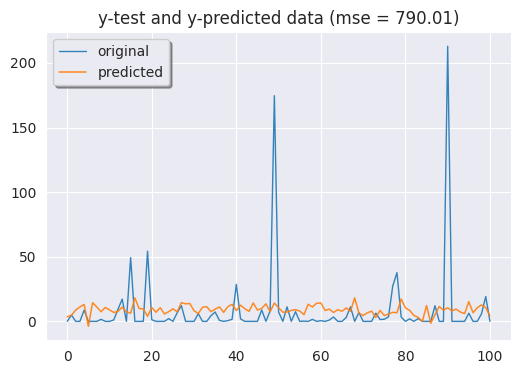

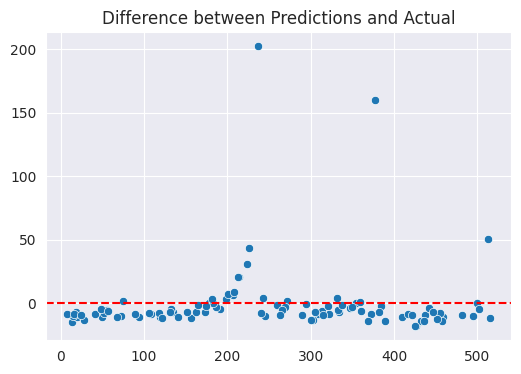

In [95]:
# generate ridgeCV object with range of alpha values for model to test
ridge_initial=RidgeCV(alphas=np.linspace(0.1, 10, num=100), alpha_per_target=True)

# fit training data to model and print optimal alpha value
ridge_initial.fit(X_train, y_train)
alpha_inital=ridge_initial.alpha_ 

# print optimal alpha value calculated by model
print(alpha_inital)

# make predictions, calculate mse and graph results
prediction=ridge_initial.predict(X_test)
mse=mean_squared_error(y_test, prediction)
graph_test_accuracy(y_test, prediction, mse) 

After optimizing alpha value parameter, MSE did not improve and optimal alpha value of 0.1. 

Next will try to improve results by using [PCA transformer](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to reduce dimensionality of predictor variables.

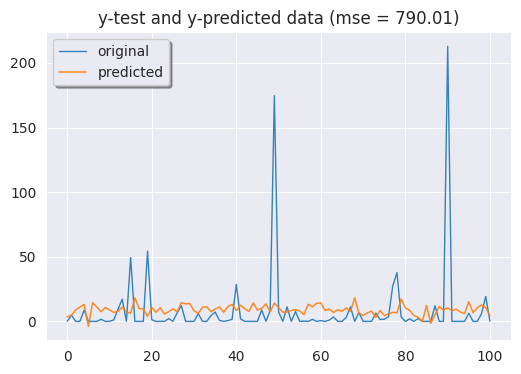

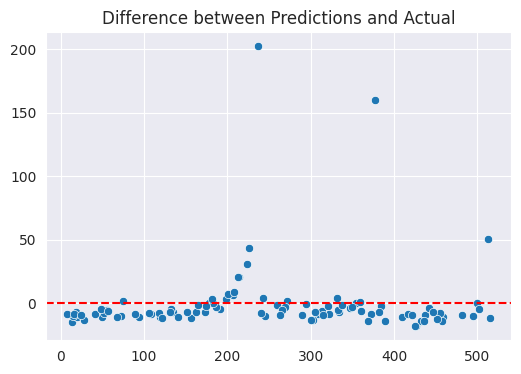

In [96]:
# initalize PCA (principal comonent analysis) Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space
pca=PCA()

# fit train and test dataset to PCA transformer
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# initialize RidgeCV object
model=RidgeCV(alphas=np.linspace(0.1,12, num=100), alpha_per_target=True)

# fit pca transformed predictor variables to model
model.fit(X_train_pca , y_train)

# make predictions, calculate mse and graph results
prediction=model.predict(X_test_pca)
mse=mean_squared_error(y_test, prediction)
graph_test_accuracy(y_test, prediction, mse)

No improvement when using PCA transformer.  Will attempt to improve results by using polynomial and spline transformers

<a id='Poly'></a>
## Polynomial and Spline Transformation

Next will attempt to use [polynomial](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) and [spline](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.SplineTransformer.html) transformations on predictive variables.  The data is unlikely to be strictly linear and doing these transformations should improve accuracy.  The downside of such transformations is that while accuracy may increase the model has difficulty extrapolating future events outside of the model and increased risk of overfitting. 


Below are some examples using simple random data from this
[source](https://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html).

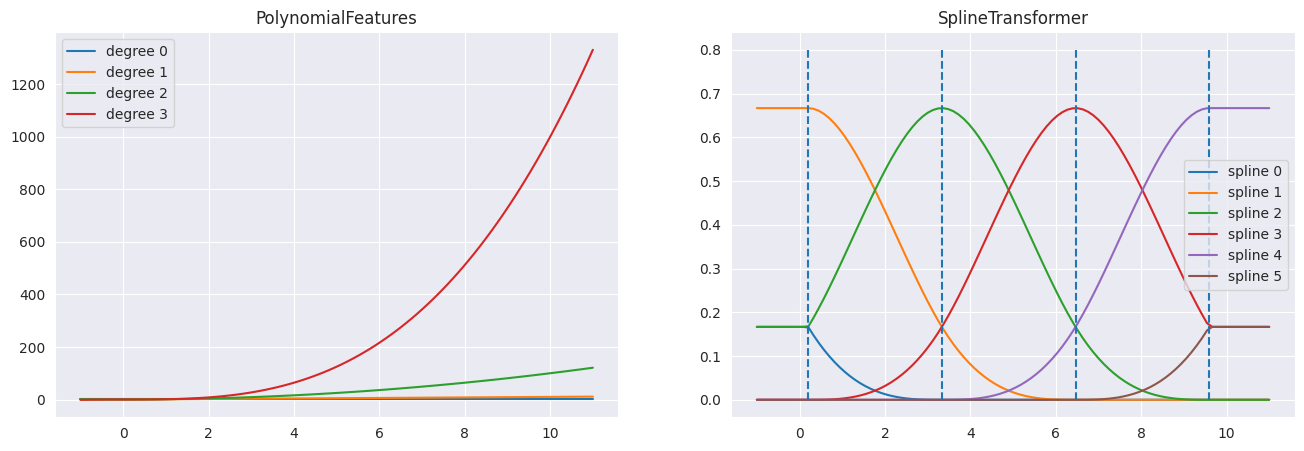

In [97]:
def f(x):
    """Function to be approximated by polynomial interpolation."""
    return x * np.sin(x)

# whole range we want to plot
x_plot = np.linspace(-1, 11, 100)

x_t = np.linspace(0, 10, 100)
rng = np.random.RandomState(0)
x_t = np.sort(rng.choice(x_t, size=20, replace=False))
y_t = f(x_t)

# create 2D-array versions of these arrays to feed to transformers
X_t = x_t[:, np.newaxis]
X_plot = x_plot[:, np.newaxis]

fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
pft = PolynomialFeatures(degree=3).fit(X_t)
axes[0].plot(x_plot, pft.transform(X_plot))
axes[0].legend(axes[0].lines, [f"degree {n}" for n in range(4)])
axes[0].set_title("PolynomialFeatures")

splt = SplineTransformer(n_knots=4, degree=3).fit(X_t)
axes[1].plot(x_plot, splt.transform(X_plot))
axes[1].legend(axes[1].lines, [f"spline {n}" for n in range(6)])
axes[1].set_title("SplineTransformer")

# plot knots of spline
knots = splt.bsplines_[0].t
axes[1].vlines(knots[3:-3], ymin=0, ymax=0.8, linestyles="dashed")
plt.show()

To the left is an example of polynomial features using increasing amounts of degrees from (X^0 to X^3)

In the right figure, there are six B-spline basis functions of degree=3 and also the four knot positions that were chosen during fit of the randomly generated data.

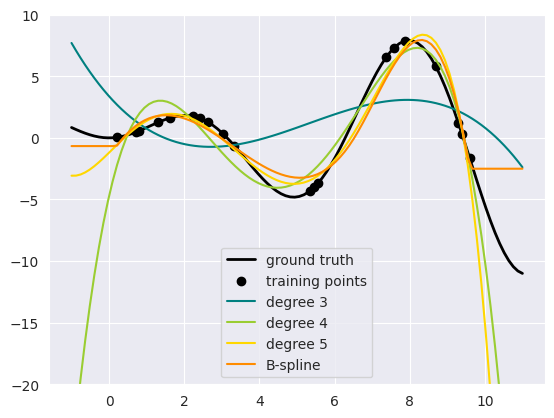

In [98]:
# plot function
lw = 2
fig, ax = plt.subplots()
ax.set_prop_cycle(
    color=["black", "teal", "yellowgreen", "gold", "darkorange", "tomato"]
)
ax.plot(x_plot, f(x_plot), linewidth=lw, label="ground truth")

# plot training points
ax.scatter(x_t, y_t, label="training points")

# polynomial features
for degree in [3, 4, 5]:
    model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=1e-3))
    model.fit(X_t, y_t)
    y_plot = model.predict(X_plot)
    ax.plot(x_plot, y_plot, label=f"degree {degree}")

# B-spline with 4 + 3 - 1 = 6 basis functions
model = make_pipeline(SplineTransformer(n_knots=4, degree=3), Ridge(alpha=1e-3))
model.fit(X_t, y_t)

y_plot = model.predict(X_plot)
ax.plot(x_plot, y_plot, label="B-spline")
ax.legend(loc="lower center")
ax.set_ylim(-20, 10)
plt.show()

The figure above demonstrates that higher degree polynomials can often fit data better than a strict linear model.

Next we will transform the training and test predictive variables with the polynomial features transfomer.

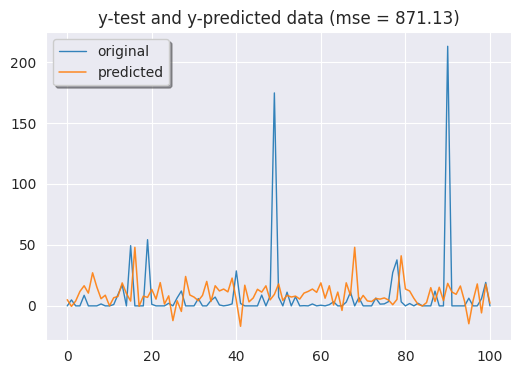

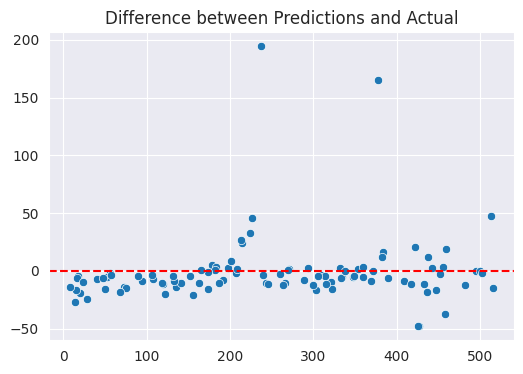

In [99]:
# initialze polynomial features transformer
poly=PolynomialFeatures(degree=2, include_bias=False)

# fit train and test data to polynomial transformer
poly_X_train=poly.fit_transform(X_train)
poly_X_test=poly.fit_transform(X_test)

# initialize RidgeCV object
model=RidgeCV(alphas=np.linspace(0.1,12, num=100), alpha_per_target=True)

# fit polynomial transformed predictor variables to model
model.fit(poly_X_train , y_train)

# make predictions, calculate mse and graph results
prediction=model.predict(poly_X_test)
mse=mean_squared_error(y_test, prediction)
graph_test_accuracy(y_test, prediction, mse)

Substantial increase in MSE after transformation.  Now will use use spline transformer.

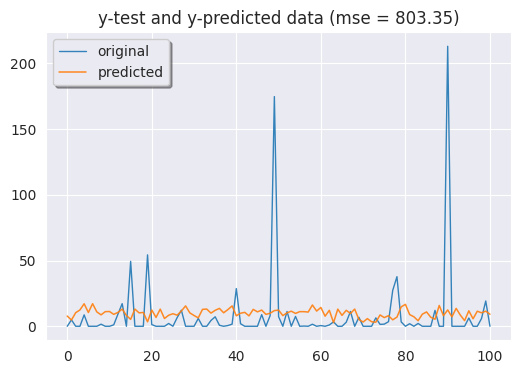

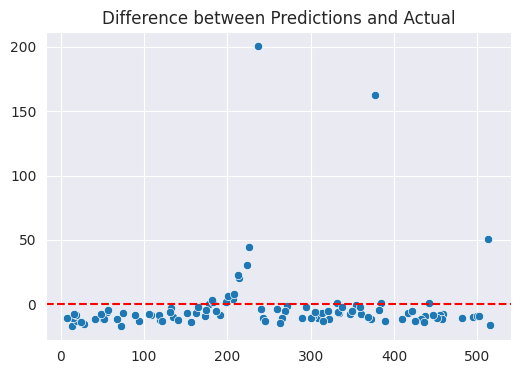

In [100]:
# initialize spline transformer with default parameters
spline = SplineTransformer()

# fit train and test data to spline transformer  
spline_X_train = spline.fit_transform(X_train)
spline_X_test = spline.fit_transform(X_test)

model=RidgeCV(alphas=np.linspace(0.1,10, num=100), alpha_per_target=True)

# fit spline transformed predictor variables to model
model.fit(spline_X_train, y_train)

# make predictions, calculate mse and graph results
prediction=model.predict(spline_X_test)
mse=mean_squared_error(y_test, prediction)
graph_test_accuracy(y_test, prediction, mse)

MSE is very similar to the untransformed data.  Next will try to find the optimum number of knots and degrees for the spline transformation.

In [101]:
# empty list to contain mse results for different knots/degree values
knot_mse=[]

# loop through 2 to 5 degrees
for degree in range(2,6):
  # loop through 2 to 14 knots
  for knot in range(2,15):
    # generate spline transformer object with varying degrees/knot values
    spline=SplineTransformer(degree=degree, n_knots=knot)
    # fit train and test data to spline transfomer
    spline_X_train = spline.fit_transform(X_train)
    spline_X_test = spline.fit_transform(X_test)
    # generate RidgeCV object
    model=RidgeCV(alphas=np.linspace(0.1,12, num=100), alpha_per_target=True)
    # fit transformed data to model
    model.fit(spline_X_train, y_train)
    # make predictions with transformed data
    prediction=model.predict(spline_X_test)
    mse=mean_squared_error(y_test, prediction)
    # append degree, knot and mse to list
    knot_mse.append([degree, knot, mse])


In [102]:
# create dataframe from knot_mse list
knot_df=pd.DataFrame(knot_mse, columns=['degree', 'n_knots', 'mse'])
# sort values by mse
knot_df=knot_df.sort_values('mse')
knot_df.head(10)

,degree,n_knots,mse
13,3,2,787.874481
1,2,3,788.087473
39,5,2,788.302284
26,4,2,788.601511
27,4,3,788.975828
0,2,2,789.475088
40,5,3,789.688791
41,5,4,792.057830
14,3,3,792.574234
15,3,4,794.191041


A degree of 3 with number of knots of 2 is optimal.

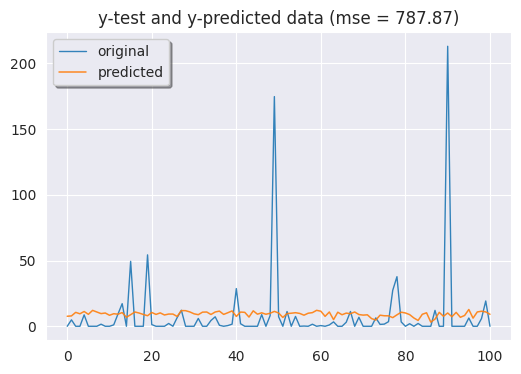

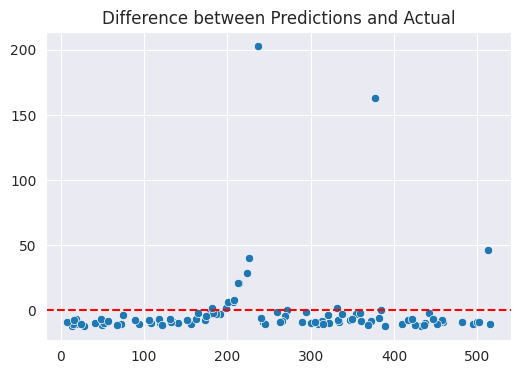

In [103]:
# create spline object with optimal parameters and then transfrom data
spline = SplineTransformer(degree=3, n_knots=2)
    
spline_X_train = spline.fit_transform(X_train)
spline_X_test = spline.fit_transform(X_test)

model=RidgeCV(alphas=np.linspace(0.1,12, num=100), alpha_per_target=True)
model.fit(spline_X_train , y_train)

# create predictions, calculate mse and graph results
prediction=model.predict(spline_X_test)
mse=mean_squared_error(y_test, prediction)
graph_test_accuracy(y_test, prediction, mse)

<a id='Conclusion'></a>
## Conclusion

Was able to decrease MSE from an initial value of about 12,000 to 788.  This increase in accuracy were due to three factors:


1.   Change to RidgeCV model from simple Linear Regression
2.   Removing outliers
3.   Using spline transformation with optimal degree and knot values

MSE could of been lowered further still by simply narrowing range of standard deviations to keep.  While doing this might improve the model it would also make the model less use from a practical stand point.  The purpose of the exercise is to predict forest fires.  A model used to predict fires trained on data with practically no substantial fires would be pointless.  

Also, the outliers may not of turned out to be actual outliers in a larger dataset.  If the dataset was larger over a longer period of time, such large events maybe more prevelant making modeling such events much easier and more predictable.

